In [2]:
import argparse
import json
import os

import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

from utils.common import tti
from utils.uv_renderer import UVRenderer

import models
from models.renderer import Renderer
from models.generator import Generator
import pickle
import smplx


from utils.bbox import get_ltrb_bbox, crop_resize_verts
from utils.common import get_rotation_matrix, rotate_verts, to_sigm

#### Hyperparameters

In [3]:
device = torch.device("cuda:0")
checkpoint_path = "./data/checkpoint/generative_model.pth"
smplx_dict_path = "./data/inference_samples/azure_01/00_smplx.pkl"
smplx_model_dir = "./data/smplx/"

#### Helper Functions

In [4]:
def load_model(checkpoint_path='./data/checkpoints/generative_model.pth', device='cuda:0'):
    ainp_path = 'data/spectral_texture16.pth'
    ainp_scales = [64, 128, 256, 512]

    ainp_tensor = torch.load(ainp_path)
    generator = Generator(ainp_tensor=ainp_tensor, ainp_scales=ainp_scales).to(device)
    renderer = Renderer().to(device)

    checkpoint = torch.load(checkpoint_path)
    generator.load_state_dict(checkpoint['g'])
    renderer.load_state_dict(checkpoint['r'])

    generator.eval()
    renderer.eval()

    return renderer, generator

def build_smplx_model_dict(smplx_model_dir, device):
    gender2filename = dict(neutral='SMPLX_NEUTRAL.npz', male='SMPLX_MALE.npz', female='SMPLX_FEMALE.npz')
    gender2path = {k:os.path.join(smplx_model_dir, v) for (k, v) in gender2filename.items()}
    gender2model = {k:smplx.body_models.SMPLX(v).to(device) for (k, v) in gender2path.items()}

    return gender2model

#### Load Models

In [5]:
renderer, generator = load_model(checkpoint_path = checkpoint_path)
uv_renderer = UVRenderer(H = 512, W = 512).to(device)
smplx_models_dict = build_smplx_model_dict(smplx_model_dir, device)
v_inds = torch.LongTensor(np.load('./data/v_inds.npy')).to(device)

/home/ubuntu/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


#### Generate Texture from Generator

In [6]:
z_val = [models.styleganv2.modules.make_noise(batch=1, latent_dim=512, n_noise=1, device=device)]
ntexture = generator(z_val)
#ntexture = torch.load("./data/spectral_texture16.pth", map_location=device)

#### Generate Mesh & Camera Parameters from SMPLX

In [7]:
with open(smplx_dict_path, 'rb') as f:
        smpl_params = pickle.load(f, encoding='latin1')
print (smpl_params.keys())

gender = smpl_params['gender']

for k, v in smpl_params.items():
    if type(v) == np.ndarray:
        if 'hand_pose' in k:
            v = v[:, :6]
        smpl_params[k] = torch.FloatTensor(v).to(device)

smpl_output = smplx_models_dict[gender](**smpl_params)
print (smpl_output)
vertices = smpl_output.vertices
vertices = vertices[:, v_inds]
K = smpl_params['camera_intrinsics'].unsqueeze(0)
vertices = torch.bmm(vertices, K.transpose(1, 2))

ltrb = get_ltrb_bbox(vertices)
vertices, K = crop_resize_verts(vertices, K, ltrb, new_image_size=512)

dict_keys(['betas', 'expressions', 'global_orient', 'transl', 'body_pose', 'jaw_pose', 'leye_pose', 'reye_pose', 'left_hand_pose', 'right_hand_pose', 'camera_intrinsics', 'gender'])
SMPLXOutput(vertices=tensor([[[ 0.1204, -0.6505,  1.4245],
         [ 0.1242, -0.6490,  1.4231],
         [ 0.1246, -0.6505,  1.4226],
         ...,
         [ 0.0129, -0.6639,  1.3761],
         [ 0.0153, -0.6640,  1.3767],
         [ 0.0177, -0.6642,  1.3768]]], device='cuda:0',
       grad_fn=<AsStridedBackward>), joints=tensor([[[ 0.0796, -0.0595,  1.5206],
         [ 0.1356,  0.0277,  1.5478],
         [ 0.0305,  0.0408,  1.5501],
         [ 0.0781, -0.1671,  1.5463],
         [ 0.1767,  0.4162,  1.6303],
         [ 0.0070,  0.4150,  1.6152],
         [ 0.0864, -0.3103,  1.5453],
         [ 0.1322,  0.8136,  1.7428],
         [ 0.0443,  0.8225,  1.7368],
         [ 0.0736, -0.3594,  1.5158],
         [ 0.1892,  0.8733,  1.6187],
         [-0.0252,  0.8850,  1.6163],
         [ 0.0599, -0.5166,  1.5171]

#### Render Image

In [8]:
uv = uv_renderer(vertices, negbg=True)
nrender = torch.nn.functional.grid_sample(ntexture, uv.permute(0, 2, 3, 1), align_corners=True)
renderer_input = dict(uv=uv, nrender=nrender)

with torch.no_grad():
    renderer_output = renderer(renderer_input)

fake_rgb = renderer_output['fake_rgb']
fake_segm = renderer_output['fake_segm']
fake_rgb = to_sigm(fake_rgb) * (fake_segm > 0.8)
fake_rgb = (tti(fake_rgb) * 255).astype(np.uint8)

/home/ubuntu/anaconda3/envs/pytorch3d/lib/python3.8/site-packages/torch/nn/functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


In [9]:
print (fake_rgb.shape)

(1024, 1024, 3)


True

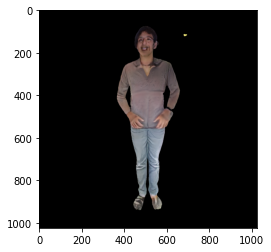

In [11]:
plt.imshow(fake_rgb)
cv2.imwrite("./rgb.png", fake_rgb[...,::-1])